In [1]:
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt 
from tqdm import tqdm
import numpy as np 
import scipy.stats as sci
from collections import defaultdict
import matplotlib.ticker as ticker

pd.options.display.max_rows = 100
pd.options.display.max_columns = None
%matplotlib inline 

## Parsing Functions

## IMBD Revenue/Budget
- [23m Dataset](https://www.kaggle.com/juzershakir/tmdb-movies-dataset)
 - Used for Gathering Revenue, Profit, and Budget

In [2]:
def budget_numeric(df):
    '''This function will make the budget column in the dataframe numeric'''
    new_col = []
    new_df = df[[i for i in df.columns.to_list() if i!= 'budget']]
    col_val = np.array(df[f'budget'])
    for item in col_val: 
        if '.jpg' in item: 
            new_col.append(None)
        else: 
            new_col.append(float(item))
    new_df['budget'] = new_col
    return new_df

def profits(df):
    '''This function will create a new column call profit by subtracting the revenue from the budget'''
    new_df = df
    new_df['profit'] = round(new_df.revenue - new_df.budget,2)
    return new_df

def dates_func(x):
    '''This function will format each x from xx-xx-xxxx to xxxx'''
    if type(x) != str: 
        return None
    else: 
        return x.split('-')[0]
def dates(df): 
    '''This function formats the date column of the dataframe so that it matches the other dataframes'''
    dates = df.release_date 
    df.drop(['release_date'], axis = 1, inplace = True)
    df['date'] = dates.map(dates_func)
    return df

def genres_one_hot(df):
    '''This function parses the genres columns and creates a new column containing only the main identifier.
    This function will also create seperate columns for each genre and put a 1 or 0 depending on if it is present
    One-Hot-Encoding'''
    genre_list = df.genres.values
    genres = defaultdict(int)
    new_genre = []
    for test,i in enumerate(genre_list): 
        
        if i[0] == '[' and i[1] == ']': 
            continue 
        dic_split = i.split('} ')
        for d in (dic_split):
            name_loc = d.find("'name': ")
            new_d= d[name_loc +9:]
            new_d = new_d[:new_d.find("'")].strip()
            #new_d = new_d[:new_d.find("'")].strip()
            genres[new_d]+=1
    for g in tqdm(genres.keys()): 
        df[f'{g}'] = [0 for i in range(len(df))]
    for pos in tqdm(range(len(df))): 
        i = df.iloc[pos].genres
        if i[0] == '[' and i[1] == ']': 
            new_genre.append(None)
            continue 
        dic_split = i.split('} ')
        for idx, d in enumerate(dic_split): 
            name_loc = d.find("'name': ")
            new_d= d[name_loc +9:]
            new_d = new_d[:new_d.find("'")].strip()
            if idx == 0:
                new_genre.append(new_d)
            df.iloc[pos, df.columns.get_loc(f'{new_d}')] = 1
    df['genre'] = new_genre
    #df.drop('genres', axis =1, inplace = True)
    df.to_csv('../UsedData/23mRevenueNEW.csv', index = False)
    return df

        

ratings_25m = pd.read_csv('../../data/m_23/movies_metadata.csv')
col = ['imdb_id', 'title', 'release_date', 'budget', 'revenue', 'genres', 'adult', 'overview']
revenue_df = ratings_25m[[i for i in col]]
revenue_df = genres_one_hot(dates(profits(budget_numeric(revenue_df))))
revenue_one_hot = genres_one_hot(revenue_df)

/Users/samuel/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
100%|██████████| 45466/45466 [00:30<00:00, 1499.27it/s]


In [3]:
revenue_one_hot.head(3)

,imdb_id,title,revenue,genres,adult,overview,budget,profit,date,Animation,Adventure,Romance,Comedy,Action,Family,History,Drama,Crime,Fantasy,Science Fiction,Thriller,Music,Horror,Documentary,Mystery,Western,TV Movie,War,Foreign,Carousel Productions,Aniplex,Odyssey Media,genre
0,tt0114709,Toy Story,373554033.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",False,"Led by Woody, Andy's toys live happily in his ...",30000000.0,343554033.0,1995,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Animation
1,tt0113497,Jumanji,262797249.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",False,When siblings Judy and Peter discover an encha...,65000000.0,197797249.0,1995,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Adventure
2,tt0113228,Grumpier Old Men,0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",False,A family wedding reignites the ancient feud be...,0.0,0.0,1995,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Romance


### MovieLens Parsing
- [MovieLens](https://grouplens.org/datasets/movielens/)
- Used to gather user interactions 

In [4]:
def dates(x):
    '''this function reformats x to the proper date'''
    num = '1 2 3 4 5 6 7 8 9 0'.split()
    if x.strip()[-1] != ')' or x.strip()[-2] not in num: 
        return None
    else: 
        return x.strip()[-5:-1]

def title(x):
    '''this function reformats the title'''
    num = '1 2 3 4 5 6 7 8 9 0'.split()
    x = x.strip()
    if x[-1] != ')' or x[-2] not in num: 
        return x
    else: 
        return x[:-5]

def sort_genres(df):
    '''This function will sort the genres in movielens to one hot encoding '''
    genre_dict = defaultdict(int)
    genre_list = np.array(df.genres)
    for genre in tqdm(genre_list): 
        g_split = genre.split('|')
        for i in g_split:
            genre_dict[i]+=1
    for g in tqdm(genre_dict.keys()): 
        df[f'{g}'] = [0 for i in range(len(df))]
    for pos in tqdm(range(len(df))): 
        row = df.iloc[pos]
        g_split = row['genres'].split('|')
        for i in g_split: 
            df.iloc[pos, df.columns.get_loc(f'{i}')] = 1
    df.to_csv('../UsedData/MovieLensMoviesCleaned.csv', index = False)
    return df

movie_lens = pd.read_csv('../../data/MovieLens/movies.csv')
movie_lens['date'] = movie_lens.title.map(dates)
title_s = movie_lens['title']
movie_lens.drop(['title'], axis = 1, inplace = True)
movie_lens['title'] = title_s.map(lambda x: x[:-6].strip())
movie_lens = movie_lens[['movieId', 'title', 'date', 'genres']].sort_values(by = ['date'], ascending = False)
movie_lens_sorted = sort_genres(movie_lens)
print(movie_lens.shape)
print(movie_lens.columns)

100%|██████████| 62423/62423 [01:06<00:00, 935.94it/s] 


(62423, 24)
Index(['movieId', 'title', 'date', 'genres', 'Comedy', 'Romance', 'Drama',
       'Children', 'Crime', 'Mystery', 'Action', 'Documentary', 'Fantasy',
       'Thriller', 'Horror', 'Animation', 'Adventure', 'Sci-Fi',
       '(no genres listed)', 'War', 'Western', 'Musical', 'IMAX', 'Film-Noir'],
      dtype='object')


In [5]:
movie_lens.head(1)

,movieId,title,date,genres,Comedy,Romance,Drama,Children,Crime,Mystery,Action,Documentary,Fantasy,Thriller,Horror,Animation,Adventure,Sci-Fi,(no genres listed),War,Western,Musical,IMAX,Film-Noir
60321,203022,"Oh, Ramona!",2019,Comedy|Romance,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Graphing Functions

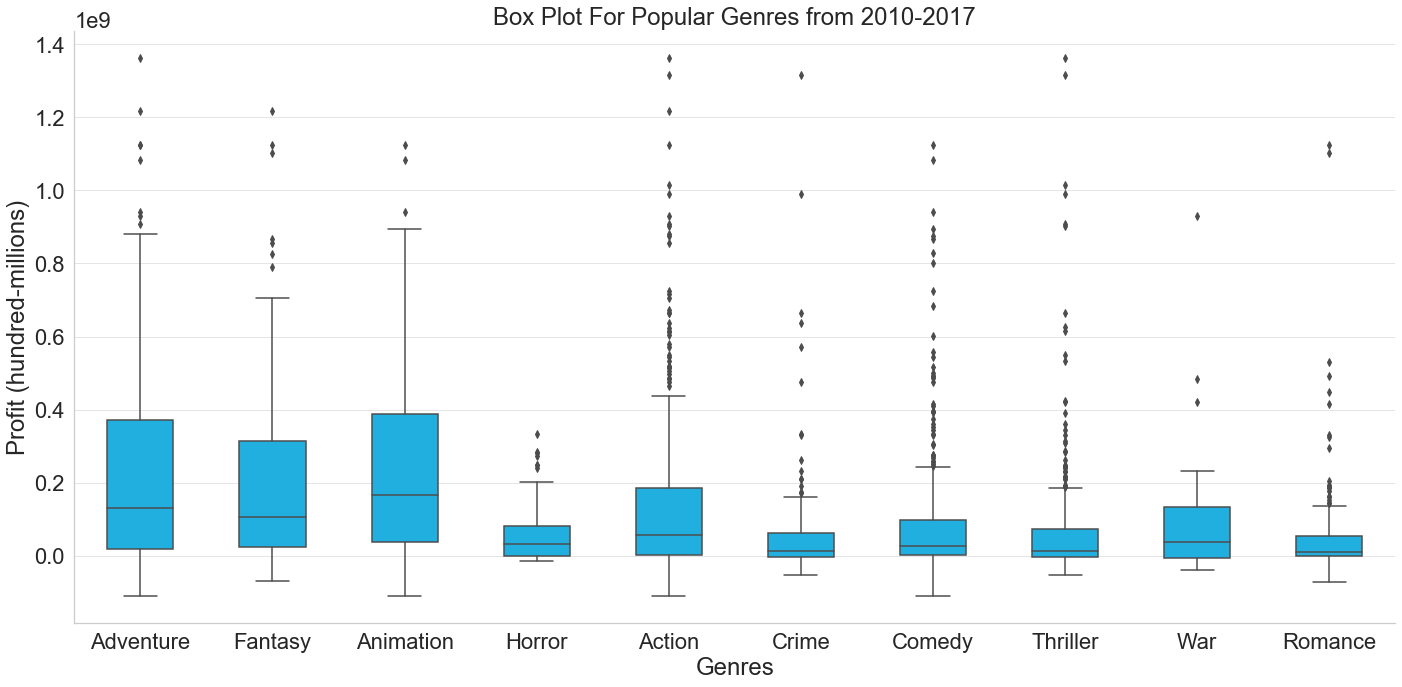

In [6]:
#creates boxplot
def box_plot(df, year, column): 
    '''This function will create a boxplot for a given column across a range of years 
    
    Parameters
    ----------
    df = Movie DataFrame 
    year = the year to start the box plot  [2015 will create a boxplot from 2015-2017 with each row as a seperate year]'
    column = column for the boxplot'''
    

    sns.set(font_scale = 2, style = 'whitegrid', rc = {'grid.linewidth': .5})
    genre_dic = defaultdict(list)
    year_dic = defaultdict(list)
    years = list(range(year, 2021))
    df = df[(df.revenue > 0) & (df.budget > 0)& (df.date >= year)] # (df.date.isin(years))]
    genre_list = 'Adventure Fantasy Animation Horror Action Crime Comedy Thriller War Romance'.split()
    new_df = pd.DataFrame(columns = ['title', 'date', 'genre', 'budget', 'revenue', 'profit'])
    for g in genre_list: 
        g_df = df[df[f'{g}'] == 1][['title', 'date', 'budget', 'revenue', 'profit']]
        g_df['genre'] = [g for i in range(len(g_df))]
        new_df = new_df.append(g_df, ignore_index = True)
    ax = sns.catplot(x = 'genre', y = 'profit', 
                     data = new_df, kind = 'box', height =10, aspect =2, legend_out = True, color = 'deepskyblue',
                    width = .5) 
    ax.set(ylabel = 'Profit (hundred-millions)', xlabel = 'Genres')
    plt.title(f'Box Plot For Popular Genres from {year}-2017')
    plt.savefig(f'../PlotImages/BoxPlot_genres_{year}.png')
    plt.show(ax)


#   

merged_df = pd.read_csv('../UsedData/Merged_ratings_movies_revenue.csv')
merged_df = merged_df[(merged_df.revenue > 0) & (merged_df.budget >0)] #making sure to use movies with a revenue and budget
box_plot(merged_df, 2010, 'profit')

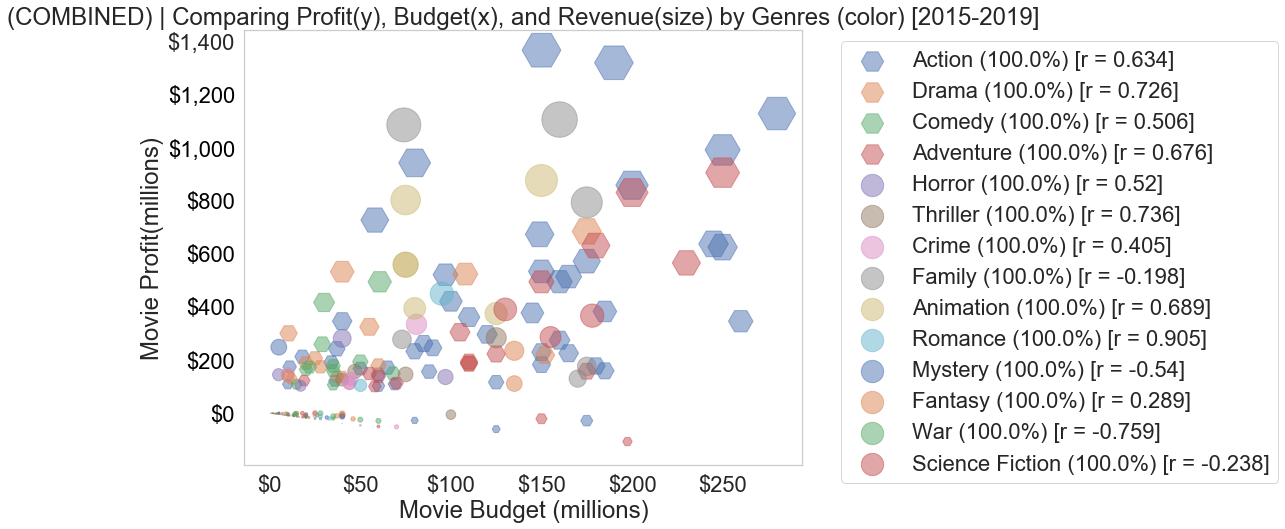

In [7]:
def scatter_sized(df, year, pos_neg = False): 
    '''This function will create a scatter plot for each genre'''
    df = df[(df.date >= year) & (df.budget > 0) & (df.revenue > 0)]
    
    fig, ax = plt.subplots(figsize = (10,8))
    count = df[(df.profit < 0) | (df.profit > 100000000)].genre.value_counts()    


    if pos_neg == 'positive':
        df = df[df.profit > 100000000]
        pos_neg = 'POSITIVE'
        s_factor = 1000000
        tick_color = 'green'
    elif pos_neg == 'negative': 
        df = df[df.profit < 0]
        pos_neg = 'NEGATIVE'
        s_factor = 100000
        tick_color = 'red'
    else: 
        df = df[(df.profit < 0) | (df.profit > 100000000)]
        pos_neg = 'COMBINED'
        s_factor = 1000000
        tick_color = 'black'
    color = pd.Categorical(df.genre.value_counts().index.to_list()).codes
    num_dic = {'#eeefff':'Action', '#F1F906': 'Drama', '2': 'Comedy', '3': 'Adventure', 
                 '4': 'Horror', '5': 'Thriller', '6': 'Crime', '7': 'Family', 
                 '8': 'Animation', '9': 'Romance', '10': 'Mystery', 
                 '11': 'Fantasy', '12': 'War', '13': 'Science Fiction'}
    genre_dic = {value:key for key, value in num_dic.items()}
    for genre in genre_dic.keys():
        genre_count = df.genre.value_counts()
        if genre in genre_count.index.to_list(): 
            g_count = genre_count[genre]
        else: 
            g_count = 0
        new_df = df[df.genre == genre]
        budget = new_df.budget /1000000
        profit = new_df.profit / 1000000
        s = new_df.revenue / s_factor
        if len(budget) < 2 or len(profit) < 2: 
            continue
        pearson = round(sci.stats.pearsonr(budget, profit)[0],3)
        if genre in ['Action', 'Comedy', 'Adventure', 'Drama']: 
            marker = 'H'
        else: 
            marker = 'o'
        perc = round((g_count / count[genre]*100), 2) 
        ax.scatter(budget, profit, cmap = genre_dic[genre], s = s, label = f'{genre} ({perc}%) [r = {pearson}]', 
                   alpha = .5, marker = marker)
    lgnd = plt.legend(bbox_to_anchor = (1.05, 1.0), loc = 'upper left')
    for i in range(len(genre_dic.keys())): 
        try:
            lgnd.legendHandles[i]._sizes = [500]
        except: 
            break
    formatter = ticker.StrMethodFormatter('${x:,.0f}')
    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_formatter(formatter)
    for ytick, xtick in zip(ax.yaxis.get_major_ticks(), ax.xaxis.get_major_ticks()): 
        ytick.label1.set_visible(True)
        ytick.label2.set_visible(False)
        ytick.label1.set_color('black')  
        xtick.label1.set_visible(True)
        xtick.label2.set_visible(False)
    
    plt.title(f'({pos_neg.upper()}) | Comparing Profit(y), Budget(x), and Revenue(size) by Genres (color) [{year}-2019]',
             fontname = 'Arial')
    plt.xlabel('Movie Budget (millions)'); plt.ylabel('Movie Profit(millions)', fontname = 'Arial')
    plt.grid()
    plt.savefig(f'../PlotImages/profit_budget_revenue_{pos_neg}[{year}].png', bbox_inches = 'tight')

scatter_sized(merged_df, 2015, pos_neg = 'combined')

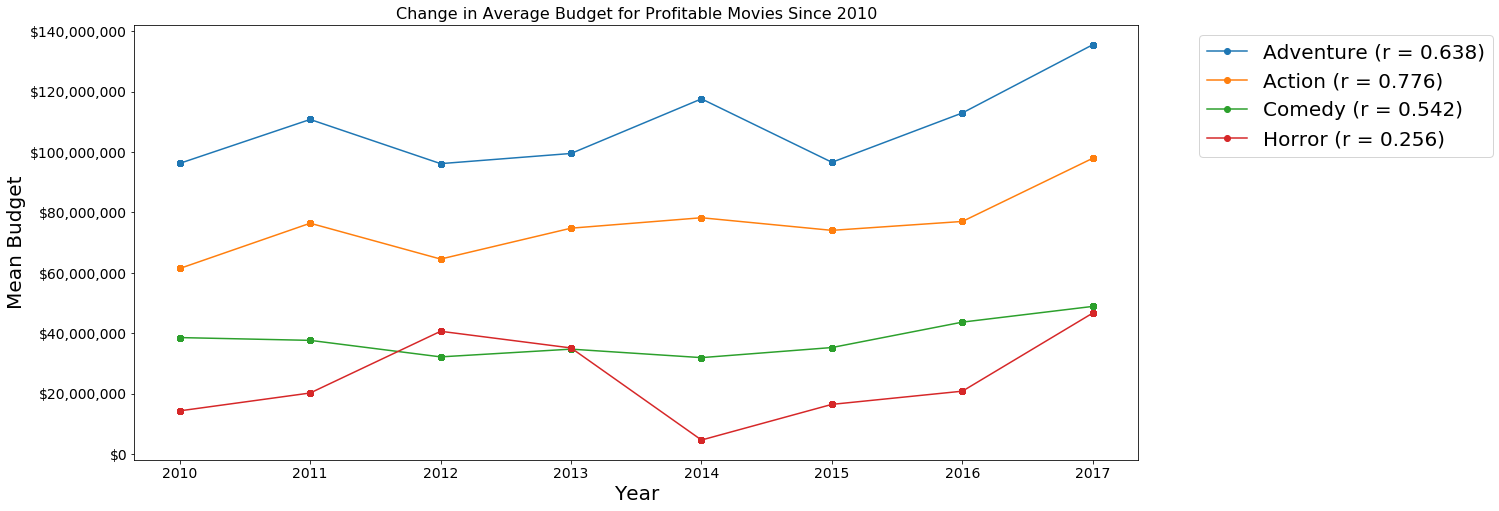

In [6]:
def budget_line_plot(df, year, column, genre_list): 
    
    num_dic = {'#eeefff':'Action', '#F1F906': 'Drama', '2': 'Comedy', '3': 'Adventure', 
                 '4': 'Horror', '5': 'Thriller', '6': 'Crime', '7': 'Family', 
                 '8': 'Animation', '9': 'Romance', '10': 'Mystery', 
                 '11': 'Fantasy', '12': 'War', '13': 'Science Fiction'}
    genre_dic = {value:key for key, value in num_dic.items()}
    
    fig, ax = plt.subplots(figsize=(18,8))


    df = df[(df.date >= year) & (df.budget > 0) & (df.revenue > 0) & (df.profit) > 0]
    new_df = pd.DataFrame(columns = ['date', 'genre', 'avg_profit'])
    for g in genre_list: 
        g_df = df[df[f'{g}'] == 1][['date', 'budget']].groupby('date').budget.mean()
        for i in g_df: 
            g_dic = {'date': [i for i in g_df.index], 'genre': [g for i in range(len(g_df))],
                    'avg_budget': g_df.values}
            g_dic = pd.DataFrame(g_dic)
            new_df = new_df.append(g_dic, ignore_index = True)
    for g in genre_list: 
        g_df = new_df[new_df.genre == g].sort_values(by = 'date')
        x = g_df.date.values 
        y = g_df.avg_budget 
        pearson = round(sci.stats.pearsonr(x, y)[0],3)
        ax.plot(x,y,label = f'{g} (r = {pearson})', marker = 'o')
    lgnd = plt.legend(bbox_to_anchor = (1.05, 1.0), loc = 'upper left')
    formatter = ticker.StrMethodFormatter('${x:,.0f}')
    ax.yaxis.set_major_formatter(formatter)
    for ytick, xtick in zip(ax.yaxis.get_major_ticks(),ax.xaxis.get_major_ticks()): 
        ytick.label1.set_visible(True)
        ytick.label2.set_visible(False)
        ytick.label1.set_color('black')
        ytick.label1.set_fontsize(14)
        xtick.label1.set_fontsize(14)
    lgnd = plt.legend(bbox_to_anchor = (1.05, 1.0), loc = 'upper left',
                     prop = {'size': 20})
    for i in range(len(genre_dic.keys())): 
        try:
            lgnd.legendHandles[i]._sizes = [500]
        except: 
            break
    plt.title(f'Change in Average Budget for Profitable Movies Since {year}', {'size':16})
    plt.xlabel('Year', {'size':20})
    plt.ylabel('Mean Budget', {'size':20})
    plt.savefig('GitImages/change_over_time_budget.png', bbox_inches = 'tight')
merged_df = pd.read_csv('UsedData/Merged_ratings_movies_revenue.csv')          
budget_line_plot(merged_df, 2010, 'profit', 'Adventure Action Comedy Horror'.split())